<center><h1>Facial Emotion Detection</h1></center>

In [1]:
!pip install scikit-plot

# Importing the dependencies and Libraries 

In [3]:
import pandas as pd
import numpy as np
import scikitplot
import random
import seaborn as sns
import keras
from sklearnex import patch_sklearn
patch_sklearn()
from matplotlib import pyplot
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import warnings
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from keras.preprocessing.image import ImageDataGenerator,load_img

from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D,Activation,Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
warnings.simplefilter("ignore")
from keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.regularizers import l1, l2
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [4]:
from tensorflow.keras.utils import plot_model

# Importing the Dataset

In [5]:
data = pd.read_csv("fer2013.csv")
data.shape

(35887, 3)

**Missing data Calculation**

In [6]:
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

**Visualizing the dataset**

In [7]:
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


# Data pre-processing

**Shuffling the data**

In [8]:
data = data.sample(frac=1)

**Encoding the labels**

In [9]:
labels = to_categorical(data[['emotion']], num_classes=7)

**Changing image pixels to Numpy array**

In [10]:
train_pixels = data["pixels"].astype(str).str.split(" ").tolist()
train_pixels = np.uint8(train_pixels)

In [11]:
pixels = train_pixels.reshape((35887*2304,1))

**Standardization**

In [12]:
scaler = StandardScaler()
pixels = scaler.fit_transform(pixels)

In [13]:
pixels = train_pixels.reshape((35887, 48, 48,1))

**Spliting the dataset into Training set, Test set, Validation set**

In [14]:
X_train, X_test, y_train, y_test = train_test_split(pixels, labels, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [15]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(29068, 48, 48, 1)
(3589, 48, 48, 1)
(3230, 48, 48, 1)


<h3>Visulazing the images</h3>

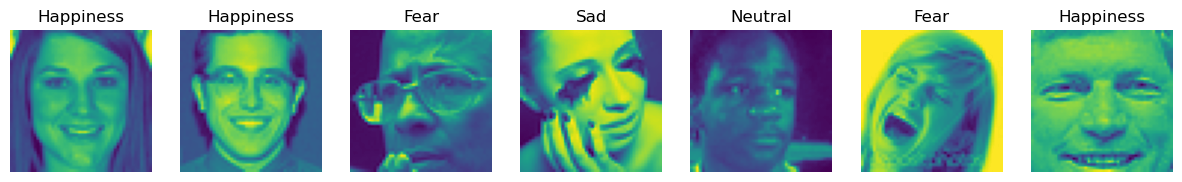

In [16]:
plt.figure(figsize=(15,23))
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}
i = 1
for i in range (7):
    img = np.squeeze(X_train[i])
    plt.subplot(1,7,i+1)
    plt.imshow(img)
    index = np.argmax(y_train[i])
    plt.title(label_dict[index])
    plt.axis('off')
    i += 1
plt.show()

 <h3>Data augmentation using ImageDataGenerator</h3>

In [17]:
data_gen = ImageDataGenerator(  width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2)
valid_gen = ImageDataGenerator(   width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               horizontal_flip = True,
                               zoom_range = 0.2) 

In [18]:
data_gen.fit(X_train)
valid_gen.fit(X_val)

In [20]:
train_generator = data_gen.flow(X_train, y_train, batch_size=64)
val_generator = data_gen.flow(X_val, y_val, batch_size=64)

<h1>Creating Deep Learning Model</h1>

In [21]:
def cnn_model():
    #Initialising the CNN
    model= tf.keras.models.Sequential()
    # First Convolution layer
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(48, 48,1)))
    # Second Convolution layer
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    # Pooling
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Adding third convolutional layer
    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
      
    # Adding fourth convolutional layer
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Adding fifth convolutional layer
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Adding sixth convolutional layer
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    # Flattening
    model.add(Flatten()) 
    
    # creating Full Connection
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
      
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Dense(7, activation='softmax'))
    model.compile(optimizer = Adam(lr=0.0001), 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    return model

In [22]:
model = cnn_model()

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       2

**Early stopping**

Adding checkpointer to implement Early Stopping to prevent overfitting.

In [24]:
checkpointer = [EarlyStopping(monitor = 'val_accuracy', 
                              verbose = 1, 
                              restore_best_weights=True,
                              mode="max",
                              patience = 5),
                ModelCheckpoint('best_model.h5',
                                monitor="val_accuracy",
                                verbose=1,
                                save_best_only=True,
                                mode="max")]

**Training the model**

In [25]:
history = model.fit(train_generator,
                    epochs=30,
                    batch_size=64,   
                    verbose=1,
                    callbacks=[checkpointer],
                    validation_data=val_generator)

Epoch 1/30
455/455 [==============================] - ETA: 0s - loss: 6.7817 - accuracy: 0.2116
Epoch 1: val_accuracy improved from -inf to 0.25728, saving model to best_model.h5
455/455 [==============================] - 351s 771ms/step - loss: 6.7817 - accuracy: 0.2116 - val_loss: 2.5015 - val_accuracy: 0.2573
Epoch 2/30
455/455 [==============================] - ETA: 0s - loss: 2.3493 - accuracy: 0.2366
Epoch 2: val_accuracy did not improve from 0.25728
455/455 [==============================] - 372s 817ms/step - loss: 2.3493 - accuracy: 0.2366 - val_loss: 2.3932 - val_accuracy: 0.2133
Epoch 3/30
455/455 [==============================] - ETA: 0s - loss: 2.4218 - accuracy: 0.3050
Epoch 3: val_accuracy improved from 0.25728 to 0.28638, saving model to best_model.h5
455/455 [==============================] - 383s 842ms/step - loss: 2.4218 - accuracy: 0.3050 - val_loss: 2.8894 - val_accuracy: 0.2864
Epoch 4/30
455/455 [==============================] - ETA: 0s - loss: 2.6136 - accuracy

# Visualizing results

**Loss Plot**

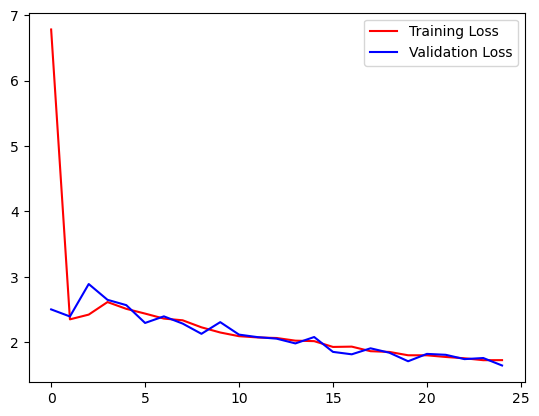

In [26]:
plt.plot(history.history["loss"],'r', label="Training Loss")
plt.plot(history.history["val_loss"],'b', label="Validation Loss")
plt.legend()

**Accuracy of the model**

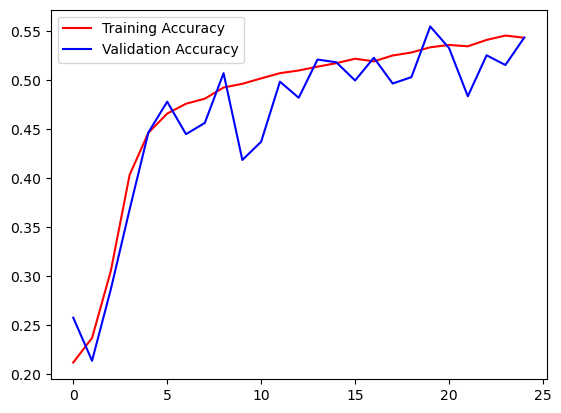

In [27]:
plt.plot(history.history["accuracy"],'r',label="Training Accuracy")
plt.plot(history.history["val_accuracy"],'b',label="Validation Accuracy")
plt.legend()

**Evaluating the Accuracy of the model**

In [28]:
loss = model.evaluate(X_test,y_test) 
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 9s 83ms/step - loss: 1.6782 - accuracy: 0.5553
Test Acc: 0.5553078651428223


**Predicting Emotion**

In [29]:
preds = model.predict(X_test)
y_pred = np.argmax(preds , axis = 1 )

113/113 [==============================] - 10s 85ms/step


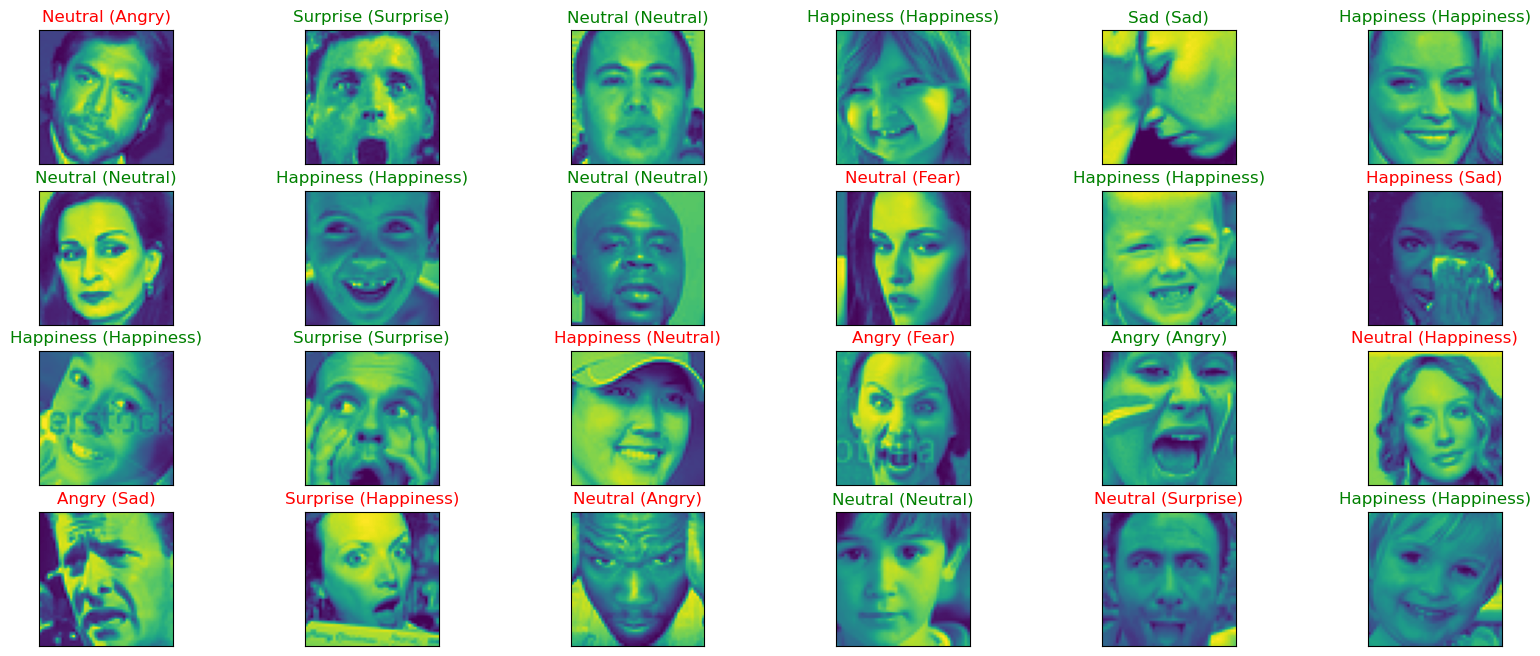

In [30]:
label_dict = {0 : 'Angry', 1 : 'Disgust', 2 : 'Fear', 3 : 'Happiness', 4 : 'Sad', 5 : 'Surprise', 6 : 'Neutral'}

figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(X_test.shape[0], size=24, replace=False)):
    ax = figure.add_subplot(4, 6, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(X_test[index]))
    predict_index = label_dict[(y_pred[index])]
    true_index = label_dict[np.argmax(y_test,axis=1)[index]]
    
    ax.set_title("{} ({})".format((predict_index), 
                                  (true_index)),
                                  color=("green" if predict_index == true_index else "red"))

In [32]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test, axis = 1 ),y_pred,digits=3))

              precision    recall  f1-score   support

           0      0.447     0.439     0.443       481
           1      0.000     0.000     0.000        65
           2      0.371     0.071     0.119       508
           3      0.775     0.862     0.816       907
           4      0.449     0.407     0.427       602
           5      0.717     0.675     0.695       406
           6      0.411     0.718     0.523       620

    accuracy                          0.555      3589
   macro avg      0.453     0.453     0.432      3589
weighted avg      0.536     0.555     0.523      3589



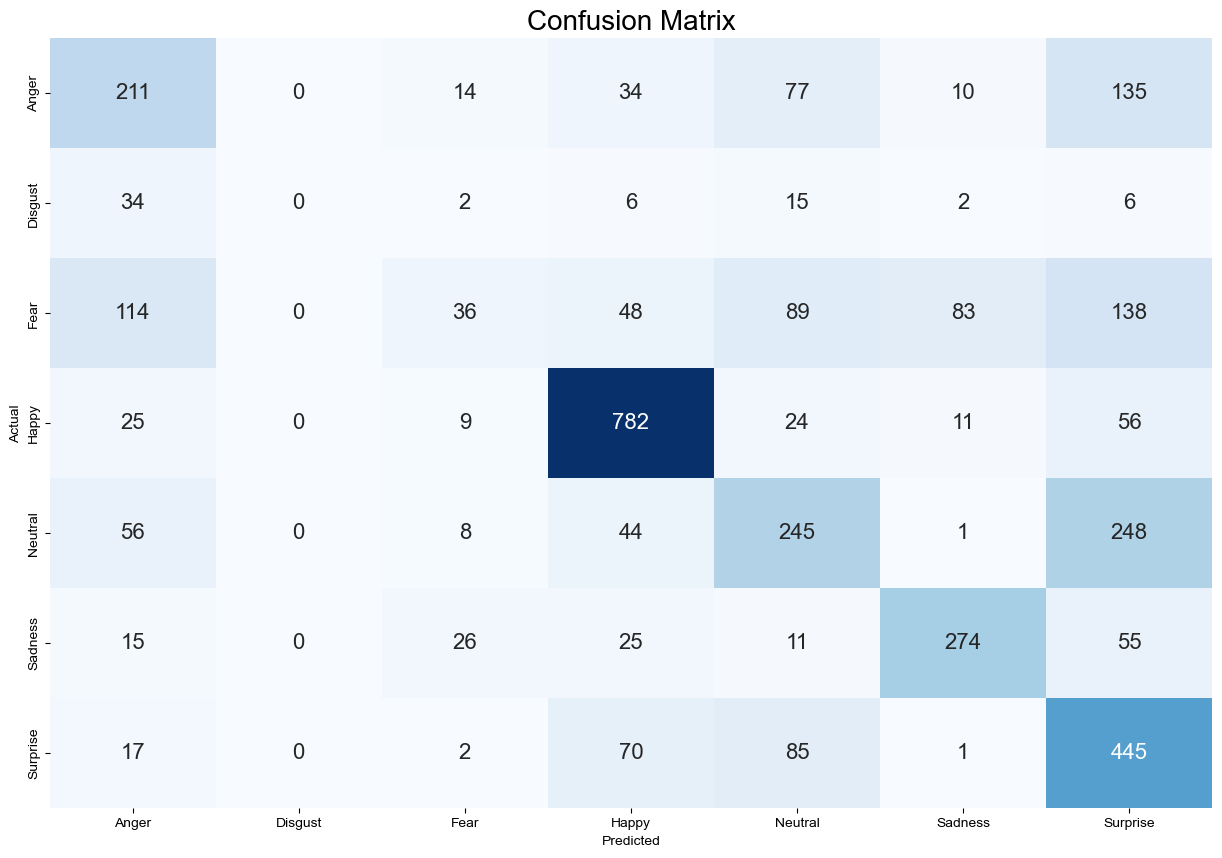

In [31]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 16}, fmt='g')